In [3]:
import numpy as np
import mne
from mne.preprocessing import read_ica
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP, SPoC
from continuous_control_bci.util import emg_classes_to_eeg_classes, SUBJECT_IDS
from tqdm import tqdm
import matplotlib as plt

from continuous_control_bci.data.load_data import load_calibration, load_driving
from continuous_control_bci.data.preprocessing import make_epochs, epochs_to_train_test
from continuous_control_bci.modelling.csp_classifier import create_csp_classifier, get_driving_epochs_for_csp
from sklearn.metrics import f1_score

How many and which channels should i specifically look at? C3, C4 and surrounding?
TODO:
First train the algorithm based on the calibration data, then load eeg data and use sliding window on that to make cont predictions.
Try both CSP and SPoC, how do i evaluate the predictions?

After that think of a way to combine EEG and EMG

Use this in a more online setting with datastreams (if possible)

In [4]:
# Define used functions here:
def get_windows(data, window_size, sample_rate):
    """"
    Sliding window for the EEG data, currently steps 1 second
    - data: numpy array
    - window size: size in seconds

    - returns: a numpy array for that current window
    """
    step = int(sample_rate*window_size)
    windows = []
    for start in range(0, data.shape[1]-step+1, step):
        end = start + step
        windows.append(data[:,start:end])
    return windows

def create_csp_svm_classifier(X_train: np.ndarray, y_train: np.ndarray, rank):
    """
    Trains a CSP classifier on all the data.
    First, however it runs 5-fold cross validation to make cross-validated predictions.
    This the resulting predictions are returns for a fair evaluation, with an optimal model for the training data.
    :param X_train:
    :param y_train:
    :return:
    """
    clf_eeg = Pipeline([
        ("CSP", CSP(n_components=6, reg='shrinkage', log=True, rank=rank)),
        ("SVC", SVC(C=10, gamma=0.1, kernel="rbf"))]) #'SVC__C': 10, 'SVC__gamma': 0.1, 'SVC__kernel': 'rbf'
    param_grid = {'SVC__C': [0.1, 1, 10, 100, 1000],
                  'SVC__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'SVC__kernel': ['rbf', 'gauss']}
#    search = GridSearchCV(clf_eeg, param_grid, n_jobs=2, cv=5)
#    search.fit(X_train, y_train)
#    print("BEST PARAMETERS!!!!!!!",search.best_params_)
#    params = search.get_params()

    y_pred = cross_val_predict(clf_eeg, X_train, y_train, cv=5)

    clf_eeg.fit(X_train, y_train)

    return clf_eeg, y_pred #params

def create_csp_svr_classifier(X_train: np.ndarray, y_train: np.ndarray, rank):
    """
    Trains a CSP classifier on all the data.
    First, however it runs 5-fold cross validation to make cross-validated predictions.
    This the resulting predictions are returns for a fair evaluation, with an optimal model for the training data.
    :param X_train:
    :param y_train:
    :return:
    """

    clf_eeg = Pipeline([
        ("CSP", CSP(n_components=6, reg='shrinkage', log=True, rank=rank)),
        ("SVR", SVR())])

    y_pred = cross_val_predict(clf_eeg, X_train, y_train, cv=5)

    clf_eeg.fit(X_train, y_train)

    return clf_eeg, y_pred

First ill only take a look at one participant and if that is working ill make a python file and loop over all subjects:

In [3]:
subject_id = 280
include_rest = True
raw = load_calibration(subject_id)
raw.set_eeg_reference()
raw.filter(l_freq=5, h_freq=35)

ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(raw)

epochs = make_epochs(raw, include_rest=include_rest)
X_train, _, y_train, _ = epochs_to_train_test(epochs)
print("Training classifier. This may take a while..")
rank = {
    'eeg': X_train.shape[1] - len(ica.exclude),
    'mag': 32,
}
clf, y_pred = create_csp_classifier(X_train, y_train, rank)
svm_model, y_svm_pred = create_csp_svm_classifier(X_train, y_train, rank)
print("Classifier trained!")


Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P280\motor-imagery-csp-280-acquisition-[2024.02.02-16.08.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P280-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29

In [4]:
print(f"Subject {subject_id} calibration")
print(classification_report(y_train, y_pred, target_names=["Left", "Right", "Rest"]))


print(f"Subject {subject_id} SVM calibration")
print(classification_report(y_train, y_svm_pred, target_names=["Left", "Right", "Rest"]))


Subject 280 calibration
              precision    recall  f1-score   support

        Left       0.47      0.42      0.44        19
       Right       0.50      0.30      0.37        20
        Rest       0.62      0.78      0.69        40

    accuracy                           0.57        79
   macro avg       0.53      0.50      0.50        79
weighted avg       0.55      0.57      0.55        79

Subject 280 SVM calibration
              precision    recall  f1-score   support

        Left       0.44      0.42      0.43        19
       Right       0.54      0.35      0.42        20
        Rest       0.60      0.72      0.66        40

    accuracy                           0.56        79
   macro avg       0.53      0.50      0.51        79
weighted avg       0.55      0.56      0.55        79



In [5]:
driving = load_driving(subject_id)
driving.raw.set_eeg_reference()
driving.raw.filter(l_freq=5, h_freq=35)
ica.apply(driving.raw)


Creating RawArray with float64 data, n_channels=40, n_times=5527501
    Range : 0 ... 5527500 =      0.000 ...  2698.975 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,5.00 Hz
Lowpass,35.00 Hz


In [6]:
# EEG Data Stream
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
eeg_data, eeg_time = driving.raw[eeg_channel_indices]
# Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=0.2, preload=True, reject_by_annotation=False)


Not setting metadata
13494 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13494 events and 410 original time points ...
0 bad epochs dropped


In [7]:
X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)
X_driving.shape

(13494, 32, 410)

# EMG Data Stream (for ground truth?)
emg_channel_indices = mne.pick_types(raw.info, eeg=False, emg=True)
emg_data, emg_times = driving.raw[emg_channel_indices]
emg_windows = get_windows(emg_data, 0.2, 2048)


In [8]:
# Making predictions based on EEG windows
# -1 left, 0 rest, 1 right
y_driving = driving.emg_prediction_stream['time_series']
#smth wrong
y_driving = emg_classes_to_eeg_classes(y_driving)
y_driving = np.squeeze(y_driving)
print(X_driving.shape)
print(y_driving[:-1].shape)

(13494, 32, 410)
(13492,)


In [9]:
X_driving[1,:,:]

array([[ 1.15268703e-06,  8.21771666e-07,  5.05895474e-07, ...,
         2.43544512e-06,  2.82993581e-06,  3.20963376e-06],
       [ 2.39290455e-06,  2.12661805e-06,  1.85241871e-06, ...,
         1.68894412e-06,  1.72081524e-06,  1.73773717e-06],
       [ 5.52135644e-06,  5.72458768e-06,  5.89750409e-06, ...,
         4.42515120e-06,  4.73946333e-06,  5.03452066e-06],
       ...,
       [ 1.73574825e-06,  1.41242651e-06,  1.09476585e-06, ...,
         4.95142683e-07,  6.15329645e-07,  7.25358686e-07],
       [-3.35048987e-07, -8.01573796e-07, -1.25154866e-06, ...,
         5.04749707e-08,  7.87593081e-08,  9.95949961e-08],
       [-2.06555809e-07, -5.09961907e-07, -7.96158333e-07, ...,
        -3.20115414e-06, -3.35781629e-06, -3.49674843e-06]])

In [10]:
#for i in X_driving.shape[2]:
y_pred_driving = svm_model.predict(X_driving[:, :, :])
print(y_pred_driving)
print(classification_report(y_driving[:-1], y_pred_driving, target_names=["Left", "Right", "Rest"]))

[2 0 0 ... 1 1 1]


ValueError: Found input variables with inconsistent numbers of samples: [13492, 13494]

In [11]:
np.unique(y_pred_driving)

array([0, 1, 2])

In [12]:
threshold_samples = int(X_driving.shape[0] * 0.1)
clf.predict_proba(X_driving[threshold_samples:])

array([[0.70045208, 0.07065882, 0.2288891 ],
       [0.92622564, 0.00585616, 0.06791819],
       [0.35212158, 0.56474265, 0.08313578],
       ...,
       [0.19594748, 0.74663519, 0.05741733],
       [0.22255279, 0.66525178, 0.11219543],
       [0.0085502 , 0.98997545, 0.00147435]])

In [ ]:
# We're using 10% of the driving data to find the optimal threshold
def predict_against_threshold(clf, X, t):
    y_driving_pred_prob = clf.predict_proba(X)
    rest = y_driving_pred_prob[:, 2] > t
    y_driving_pred = np.array([2] * len(rest))
    y_driving_pred[~rest] = y_driving_pred_prob[~rest, :2].argmax(axis=1)
    return y_driving_pred

threshold_samples = int(X_driving.shape[0] * 0.1)
print(threshold_samples)
ts = np.linspace(0, 1, 30)
t_scores = [f1_score(y_driving[:threshold_samples], predict_against_threshold(clf, X_driving[:threshold_samples], t), average='micro') for t in ts]
best_t = ts[np.argmax(t_scores)]
y_driving_pred = predict_against_threshold(clf, X_driving[threshold_samples:], 0.2)

In [ ]:
print(y_driving_pred.shape)
print(y_driving[threshold_samples:].shape)
print(y_driving_pred.shape[0]-y_driving[threshold_samples:].shape[0])
print(y_driving_pred.shape)

print(t_scores)

In [ ]:
target_names = ["Left", "Right", "Rest"]

print(classification_report(y_driving[threshold_samples:-1], y_driving_pred[:], target_names=target_names))
print(classification_report(y_driving[:-1], y_pred_driving, target_names=["Left", "Right", "Rest"]))

In [ ]:
np.unique(y_driving_pred)
clf.predict_proba

In [13]:
def get_sliding_driving_epochs_data(subject_id, duration):
    driving = load_driving(subject_id)
    driving.raw.set_eeg_reference()
    driving.raw.filter(l_freq=5, h_freq=35)
    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(driving.raw)

    eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
    eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=duration, preload=True, reject_by_annotation=False)
    X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)

    y_driving = driving.emg_prediction_stream['time_series']
    y_driving = emg_classes_to_eeg_classes(y_driving)
    y_driving = np.squeeze(y_driving)

    return X_driving, y_driving

# We're using 10% of the driving data to find the optimal threshold
def predict_against_threshold(clf, X, t):
    y_driving_pred_prob = clf.predict_proba(X)
    rest = y_driving_pred_prob[:, 2] > t
    y_driving_pred = np.array([2] * len(rest))
    y_driving_pred[~rest] = y_driving_pred_prob[~rest, :2].argmax(axis=1)
    return y_driving_pred




  0%|          | 0/18 [00:00<?, ?it/s]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied
Training classifier. This may take a while..

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)



Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 3

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.2s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13414 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13414 events and 410 original time points ...
0 bad epochs dropped
Transfer performance
              precision    recall  f1-score   support

        Left       0.50      0.80      0.61      4338
       Right       0.57      0.52      0.54      2923
        Rest       0.61      0.37      0.46      6153

    accuracy                           0.54     13414
   macro avg       0.56      0.56      0.54     13414
weighted avg       0.56      0.54      0.53     13414



  6%|▌         | 1/18 [00:44<12:36, 44.48s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P066\motor-imagery-csp-066-acquisition-[2024.01.30-18.30.01].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P066-calibration-ica.fif ...
Now restoring ICA solution ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.6s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P066-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
8277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8277 events and 410 original time points ...
0 bad epochs dropped


 11%|█         | 2/18 [01:14<09:37, 36.09s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.41      0.15      0.22      2635
       Right       0.45      0.26      0.33      1682
        Rest       0.47      0.76      0.58      3960

    accuracy                           0.46      8277
   macro avg       0.44      0.39      0.38      8277
weighted avg       0.45      0.46      0.41      8277

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P126\motor-imagery-csp-126-acquisition-[2024.02.08-15.59.48].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P126-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2', 'PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O2']
5 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'O2']
    Rejecting  epoch based on EEG : ['PO4', 'CP6', 'T8', 'FC6']
    Rejecting  epoch based on EEG : ['O2', 'PO4', 'P8']
    Rejecting  epoch based on EEG : ['

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (wi

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P126-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13219 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13219 events and 410 original time points ...
0 bad epochs dropped


 17%|█▋        | 3/18 [01:52<09:15, 37.04s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.41      0.21      0.28      4715
       Right       0.36      0.48      0.41      3242
        Rest       0.42      0.53      0.47      5262

    accuracy                           0.40     13219
   macro avg       0.40      0.40      0.39     13219
weighted avg       0.40      0.40      0.39     13219

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P280\motor-imagery-csp-280-acquisition-[2024.02.02-16.08.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P280-calibration-ica.fif ...
Now restoring ICA solution ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1', 'Oz', 'O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P280-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13494 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13494 events and 410 original time points ...
0 bad epochs dropped


 22%|██▏       | 4/18 [02:31<08:48, 37.74s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.37      0.42      0.39      4356
       Right       0.24      0.49      0.32      2798
        Rest       0.53      0.23      0.32      6339

    accuracy                           0.34     13493
   macro avg       0.38      0.38      0.34     13493
weighted avg       0.42      0.34      0.34     13493

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P302\motor-imagery-csp-302-acquisition-[2024.02.06-17.52.04].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P302-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FC5']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P302-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12939 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12939 events and 410 original time points ...
0 bad epochs dropped
Transfer performance
              precision    recall  f1-score   support

        Left       0.36      0.29      0.32      4221
       Right       0.24      0.37      0.29      3244
        Rest       0.41      0.35      0.38      5474

    accuracy                           0.33     12939
   macro avg       0.34      0.33      0.33     12939
weighted avg       0.35      0.33      0.34     12939



 28%|██▊       | 5/18 [03:09<08:09, 37.66s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P336\motor-imagery-csp-336-acquisition-[2024.02.08-14.04.05].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882751  =      0.000 ...   431.031 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P336-calibration-ica.fif ...
Now restoring ICA solution ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied
Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 28, 'mag': 32}


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 28, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 28, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 28, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 28, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 28, 'mag': 32}
    Setting small MAG eigenvalues to zero (wi

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P336-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 4 ICA components
    Projecting back using 32 PCA components
Not setting metadata
10222 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 10222 events and 410 original time points ...
0 bad epochs dropped


 33%|███▎      | 6/18 [03:39<07:03, 35.27s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.41      0.06      0.11      3977
       Right       0.28      0.05      0.09      2914
        Rest       0.33      0.89      0.48      3331

    accuracy                           0.33     10222
   macro avg       0.34      0.33      0.22     10222
weighted avg       0.34      0.33      0.22     10222

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
    Rejecting  epoch based on EEG : ['F7', 'Fp2']
3 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12972 events and 410 original time points ...
0 bad epochs dropped


 39%|███▉      | 7/18 [04:16<06:33, 35.78s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.56      0.72      0.63      4339
       Right       0.48      0.65      0.56      2722
        Rest       0.54      0.34      0.41      5911

    accuracy                           0.53     12972
   macro avg       0.53      0.57      0.53     12972
weighted avg       0.53      0.53      0.52     12972

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P406\motor-imagery-csp-406-acquisition-[2024.02.06-11.06.31].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P406-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
3 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['Oz', 'O2']
    Rejecting  epoch based on EEG : ['Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4']
    Rejecting  epoch based on EEG : ['O2']
7 bad epochs dropped
Not setting metadata
70 matchin

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P406-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12674 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12674 events and 410 original time points ...
0 bad epochs dropped


 44%|████▍     | 8/18 [04:51<05:54, 35.44s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.40      0.66      0.49      3873
       Right       0.45      0.38      0.41      2561
        Rest       0.53      0.34      0.42      6240

    accuracy                           0.45     12674
   macro avg       0.46      0.46      0.44     12674
weighted avg       0.47      0.45      0.44     12674

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P530\motor-imagery-csp-530-acquisition-[2024.02.02-12.04.47].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P530-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp1', 'C4', 'T8', 'FC6', 'F4']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
79 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.5s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P530-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Not setting metadata
8654 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8654 events and 410 original time points ...
0 bad epochs dropped


 50%|█████     | 9/18 [05:17<04:52, 32.55s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.40      0.62      0.48      3111
       Right       0.26      0.13      0.18      1941
        Rest       0.50      0.39      0.44      3577

    accuracy                           0.42      8629
   macro avg       0.39      0.38      0.37      8629
weighted avg       0.41      0.42      0.40      8629

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P587\motor-imagery-csp-587-acquisition-[2024.01.30-14.39.50].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P587-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.3s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P587-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13969 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13969 events and 410 original time points ...
0 bad epochs dropped


 56%|█████▌    | 10/18 [05:54<04:32, 34.04s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.34      0.38      0.36      4373
       Right       0.23      0.22      0.22      2898
        Rest       0.54      0.51      0.52      6698

    accuracy                           0.41     13969
   macro avg       0.37      0.37      0.37     13969
weighted avg       0.41      0.41      0.41     13969

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P643\motor-imagery-csp-643-acquisition-[2024.02.06-14.59.12].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P643-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.2s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P643-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13419 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13419 events and 410 original time points ...
0 bad epochs dropped


 61%|██████    | 11/18 [06:31<04:04, 34.92s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.39      0.35      0.37      4242
       Right       0.27      0.20      0.23      2727
        Rest       0.52      0.61      0.56      6450

    accuracy                           0.44     13419
   macro avg       0.39      0.39      0.39     13419
weighted avg       0.43      0.44      0.43     13419

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P656\motor-imagery-csp-656-acquisition-[2024.02.08-09.39.52].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P656-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['Fp2']
1 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied
Training classifier. This may take a while..

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)



Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 26, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 2

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.1s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P656-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 6 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13649 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13649 events and 410 original time points ...
0 bad epochs dropped


 67%|██████▋   | 12/18 [07:07<03:30, 35.02s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.38      0.51      0.44      4095
       Right       0.27      0.20      0.23      2808
        Rest       0.58      0.52      0.55      6746

    accuracy                           0.45     13649
   macro avg       0.41      0.41      0.40     13649
weighted avg       0.46      0.45      0.45     13649

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P744\motor-imagery-csp-744-acquisition-[2024.02.05-14.17.28].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P744-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied
Training classifier. This may take a while..


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27

D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.5s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P744-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
12294 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 12294 events and 410 original time points ...
0 bad epochs dropped


 72%|███████▏  | 13/18 [07:41<02:54, 34.81s/it]

Transfer performance
              precision    recall  f1-score   support

        Left       0.37      0.40      0.38      3865
       Right       0.21      0.44      0.29      2465
        Rest       0.56      0.29      0.38      5964

    accuracy                           0.35     12294
   macro avg       0.38      0.37      0.35     12294
weighted avg       0.43      0.35      0.36     12294

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 27, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.1s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Not setting metadata
14039 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 14039 events and 410 original time points ...
0 bad epochs dropped
Transfer performance
              precision    recall  f1-score   support

        Left       0.52      0.42      0.47      4565
       Right       0.46      0.57      0.51      3018
        Rest       0.52      0.53      0.53      6456

    accuracy                           0.50     14039
   macro avg       0.50      0.51      0.50     14039
weighted avg       0.51      0.50      0.50     14039



 78%|███████▊  | 14/18 [08:21<02:25, 36.32s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P840\motor-imagery-csp-840-acquisition-[2024.01.23-14.39.09].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P840-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.5s finished


    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F4', 'F8']
    Rejecting  epoch based on EEG : ['O2']
2 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['FC6', 'F4']
    Rejecting  epoch based on EEG : ['F8']
2 bad epochs dropped
Not setting metadata
76 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 25, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    5.6s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P840-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 7 ICA components
    Projecting back using 32 PCA components
Not setting metadata
17999 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 17999 events and 410 original time points ...
0 bad epochs dropped
Transfer performance
              precision    recall  f1-score   support

        Left       0.34      0.35      0.34      5208
       Right       0.24      0.34      0.28      3353
        Rest       0.58      0.48      0.52      9438

    accuracy                           0.41     17999
   macro avg       0.38      0.39      0.38     17999
weighted avg       0.44      0.41      0.42     17999



 83%|████████▎ | 15/18 [09:14<02:04, 41.34s/it]

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P854\motor-imagery-csp-854-acquisition-[2024.01.30-10.40.45].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P854-calibration-ica.fif ...


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.6s finished


Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
    Rejecting  epoch based on EEG : ['F8', 'Fp2']
    Rejecting  epoch based on EEG : ['Fp1', 'AF3', 'F7', 'O1', 'O2', 'FC6', 'F4', 'F8', 'AF4', 'Fp2']
2 bad epochs dropped
Not setting metadata
78 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 29, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.4s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P854-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13417 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13417 events and 410 original time points ...
0 bad epochs dropped


 83%|████████▎ | 15/18 [10:10<02:02, 40.72s/it]

Transfer performance


ValueError: Found input variables with inconsistent numbers of samples: [0, 13417]

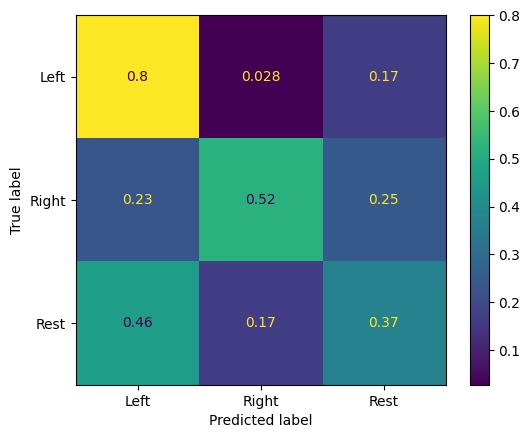

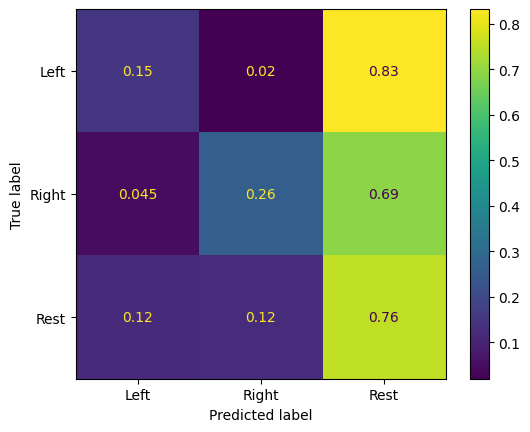

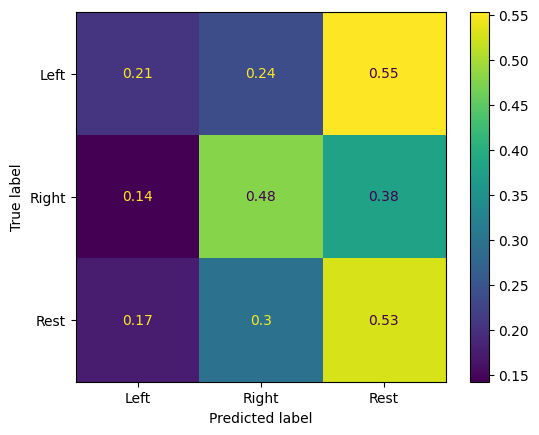

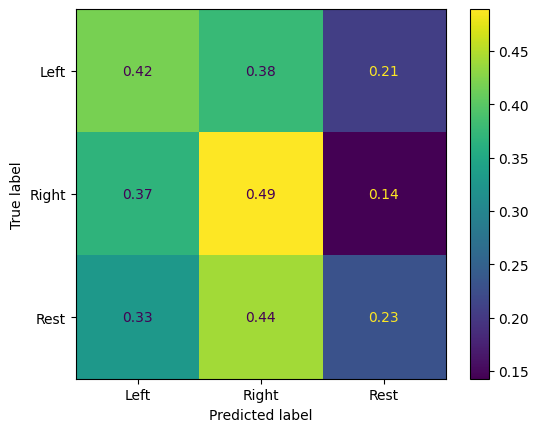

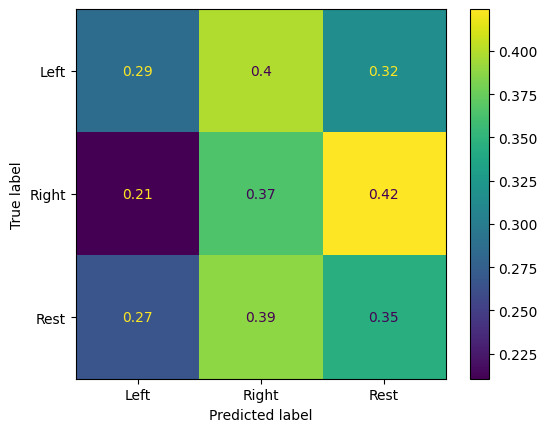

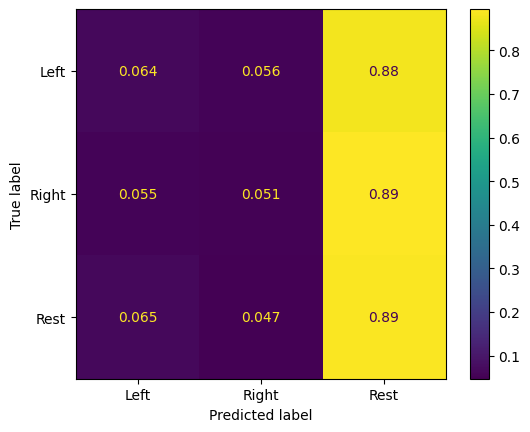

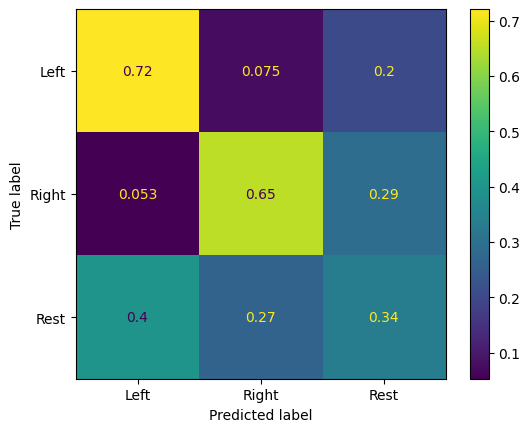

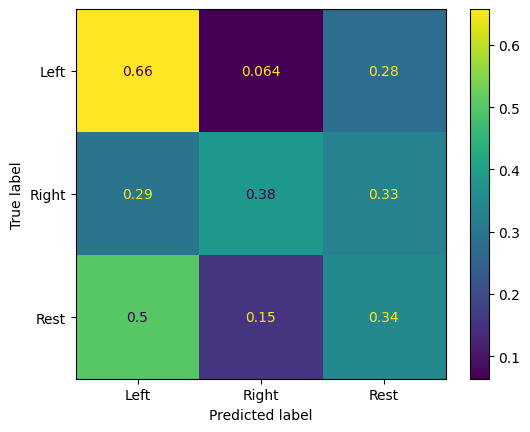

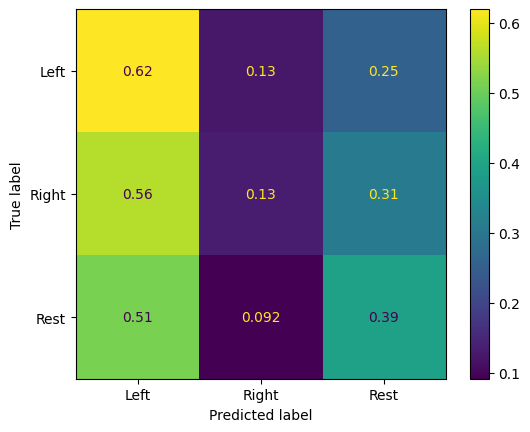

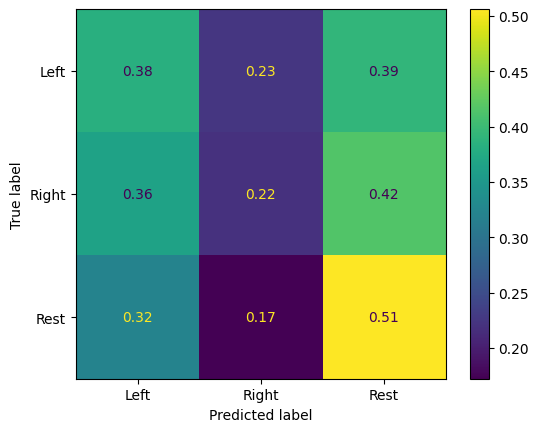

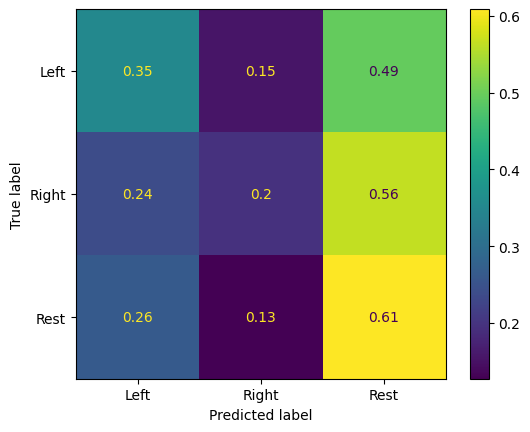

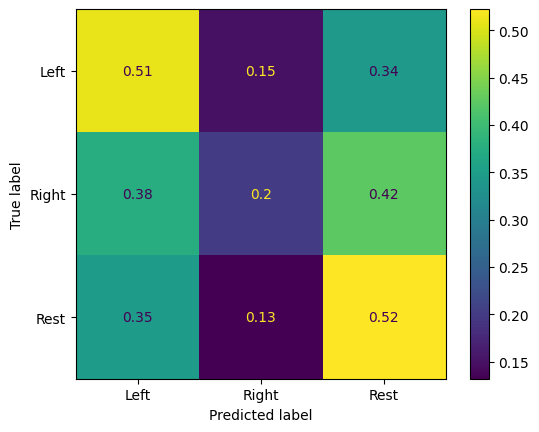

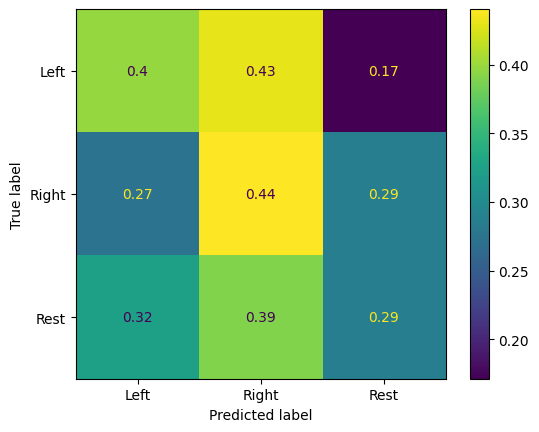

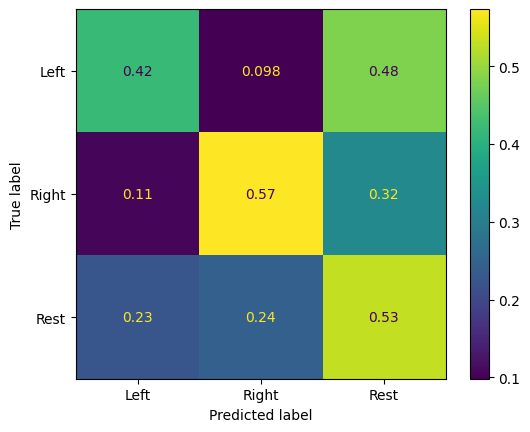

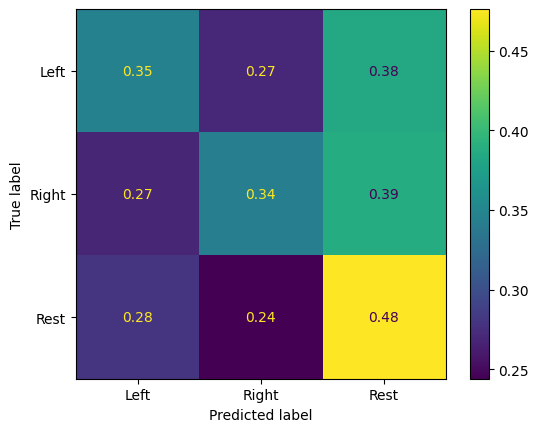

In [14]:
f1s = []
all_y_true = []
all_y_pred = []

include_rest = True
if include_rest:
    target_names = ["Left", "Right", "Rest"]
else:
    target_names = ["Left", "Right"]

for subject_id in tqdm(SUBJECT_IDS):
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    raw.filter(l_freq=5, h_freq=35)

    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(raw)

    epochs = make_epochs(raw, include_rest=include_rest)
    X_train, _, y_train, _ = epochs_to_train_test(epochs)
    print("Training classifier. This may take a while..")
    rank = {
        'eeg': X_train.shape[1] - len(ica.exclude),
        'mag': 32,
    }
    clf, y_pred = create_csp_classifier(X_train, y_train, rank)
    print("Classifier trained!")

    print(f"Subject {subject_id} calibration")
    print(classification_report(y_train, y_pred, target_names=target_names))

    X_driving, y_driving = get_sliding_driving_epochs_data(subject_id, duration=0.2)

    if X_driving.shape[0] > y_driving.shape[0]:
        diff = X_driving.shape[0]-y_driving.shape[0]
        X_driving = X_driving[:-diff,:,:]
    else:
        diff = y_driving.shape[0]-X_driving.shape[0]
        y_driving = y_driving[:-diff]

    #threshold_samples = int(X_driving.shape[0] * 0.1)
    #print(threshold_samples)
    #ts = np.linspace(0, 1, 30)
    #t_scores = [f1_score(y_driving[:threshold_samples], predict_against_threshold(clf, X_driving[:threshold_samples], t), average='micro') for t in ts]
    #best_t = ts[np.argmax(t_scores)]
    y_driving_pred = predict_against_threshold(clf, X_driving, 0.2)

    print(f"Transfer performance")
    print(classification_report(y_driving, y_driving_pred, target_names=target_names))

    ConfusionMatrixDisplay.from_predictions(y_driving, y_driving_pred, display_labels=target_names,
                                            normalize='true')
    f1 = f1_score(y_driving, y_driving_pred, average='micro')
    f1s.append(f1)
    all_y_true.append(y_driving)
    all_y_pred.append(y_driving_pred)

print(np.mean(f1s))
print(np.std(f1s))
print(f1s)
for f1 in f1s:
    print(f1)

all_y_true = np.concatenate(all_y_true)
all_y_pred = np.concatenate(all_y_pred)

print(classification_report(all_y_true, all_y_pred, target_names=target_names))
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, display_labels=target_names,
                                        normalize='true')



I take 200ms (maybe overlap of 100ms) or shorter sliding windows, make a prediction and then if multiple windows have the same prediction or based on a majority voting (testing what works better) give a final prediction for the timewindow.

 - For now using Ivos algorithm:
Make the sliding window based on larger windows. (How big should those windows be?) -> Make predicitions for those windows. (Already Implemented) -> Vote/ Cumulate last few windwos to transalte it into a prediction. How can this be evaluated? Maybe do the same with EMG predictions in the respective time windwos.
 - Frequency Bank, SVM or other Version


So i have the sliding window, it predicts something and then after certain amount of predictions i make a bigger prediction. So this means i should loop over the epochs individually and make predictions on them and then aggregate these predictions to from a final one for any given timewindow.
# No Overlap 2 second windows

In [1]:
import numpy as np
import mne
from mne.preprocessing import read_ica
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.svm import SVC, SVR
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP, SPoC
from continuous_control_bci.util import emg_classes_to_eeg_classes, SUBJECT_IDS
from tqdm import tqdm
import matplotlib as plt

from continuous_control_bci.data.load_data import load_calibration, load_driving
from continuous_control_bci.data.preprocessing import make_epochs, epochs_to_train_test
from continuous_control_bci.modelling.csp_classifier import create_csp_classifier, get_driving_epochs_for_csp
from sklearn.metrics import f1_score

In [2]:
# Define used functions here:
def get_windows(data, window_size, sample_rate):
    """"
    Sliding window for the EEG data, currently steps 1 second
    - data: numpy array
    - window size: size in seconds

    - returns: a numpy array for that current window
    """
    step = int(sample_rate*window_size)
    windows = []
    for start in range(0, data.shape[1]-step+1, step):
        end = start + step
        windows.append(data[:,start:end])
    return windows

def create_csp_svm_classifier(X_train: np.ndarray, y_train: np.ndarray, rank):
    """
    Trains a CSP classifier on all the data.
    First, however it runs 5-fold cross validation to make cross-validated predictions.
    This the resulting predictions are returns for a fair evaluation, with an optimal model for the training data.
    :param X_train:
    :param y_train:
    :return:
    """
    clf_eeg = Pipeline([
        ("CSP", CSP(n_components=6, reg='shrinkage', log=True, rank=rank)),
        ("SVC", SVC(C=10, gamma=0.1, kernel="rbf"))]) #'SVC__C': 10, 'SVC__gamma': 0.1, 'SVC__kernel': 'rbf'
    param_grid = {'SVC__C': [0.1, 1, 10, 100, 1000],
                  'SVC__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'SVC__kernel': ['rbf', 'gauss']}
    #    search = GridSearchCV(clf_eeg, param_grid, n_jobs=2, cv=5)
    #    search.fit(X_train, y_train)
    #    print("BEST PARAMETERS!!!!!!!",search.best_params_)
    #    params = search.get_params()

    y_pred = cross_val_predict(clf_eeg, X_train, y_train, cv=5)

    clf_eeg.fit(X_train, y_train)

    return clf_eeg, y_pred #params

def create_csp_svr_classifier(X_train: np.ndarray, y_train: np.ndarray, rank):
    """
    Trains a CSP classifier on all the data.
    First, however it runs 5-fold cross validation to make cross-validated predictions.
    This the resulting predictions are returns for a fair evaluation, with an optimal model for the training data.
    :param X_train:
    :param y_train:
    :return:
    """

    clf_eeg = Pipeline([
        ("CSP", CSP(n_components=6, reg='shrinkage', log=True, rank=rank)),
        ("SVR", SVR())])

    y_pred = cross_val_predict(clf_eeg, X_train, y_train, cv=5)

    clf_eeg.fit(X_train, y_train)

    return clf_eeg, y_pred

In [3]:
# Subject 61 should have fairly good EEG data and performance
subject_id = "061"
include_rest = True
raw = load_calibration(subject_id)
raw.set_eeg_reference()
raw.filter(l_freq=5, h_freq=35)

ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(raw)

epochs = make_epochs(raw, include_rest=include_rest)

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


In [4]:

X_train, _, y_train, _ = epochs_to_train_test(epochs)
print("Training classifier. This may take a while..")
rank = {
    'eeg': X_train.shape[1] - len(ica.exclude),
    'mag': 32,
}
clf, y_pred = create_csp_classifier(X_train, y_train, rank)
svm_model, y_svm_pred = create_csp_svm_classifier(X_train, y_train, rank)
print("Classifier trained!")

Training classifier. This may take a while..
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


In [5]:
driving = load_driving(subject_id)
driving.raw.set_eeg_reference()
driving.raw.filter(l_freq=5, h_freq=35)
ica.apply(driving.raw)

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\continuous_control_bci\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.6s finished


Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,35 points
Good channels,"32 EEG, 4 EMG, 4 EOG"
Bad channels,None
EOG channels,"LHEOG, RHEOG, UVEOG, LVEOG"
ECG channels,Not available
Sampling frequency,2048.00 Hz
Highpass,5.00 Hz
Lowpass,35.00 Hz


In [6]:
# EEG Data Stream
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
eeg_data, eeg_time = driving.raw[eeg_channel_indices]
# Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=0.2, preload=True, reject_by_annotation=False)

X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)

# Making predictions based on EEG windows
# -1 left, 0 rest, 1 right
y_driving = driving.emg_prediction_stream['time_series']
y_driving = emg_classes_to_eeg_classes(y_driving)
y_driving = np.squeeze(y_driving)
print(X_driving.shape)
print(y_driving[:-1].shape)

Not setting metadata
13414 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13414 events and 410 original time points ...
0 bad epochs dropped
(13414, 32, 410)
(13414,)


In [7]:
def predict_against_threshold(clf, X, t):
    y_driving_pred_prob = clf.predict_proba(X)
    rest = y_driving_pred_prob[:, 2] > t
    y_driving_pred = np.array([2] * len(rest))
    y_driving_pred[~rest] = y_driving_pred_prob[~rest, :2].argmax(axis=1)
    return y_driving_pred

def predict_against_threshold_indiv(clf, X, t):
    y_driving_pred_prob = clf.predict_proba(X)
    if y_driving_pred_prob [:, 2] > t:
        y_pred = 2
    elif y_driving_pred_prob [:, 0] > y_driving_pred_prob [:, 1]:
        y_pred = 0
    else:
        y_pred = 1

    return y_pred



In [8]:
#for epoch in X_driving:
X_driving.shape

(13414, 32, 410)

In [28]:
clf.predict_proba(X_driving[0:1,:,:])

array([[0.0339809 , 0.27647992, 0.68953918]])

In [29]:
y_preds = []
majority_pred = []
# left, right, rest
pred_direct = [0,0,0]
for i, epoch in enumerate(X_driving):
    # Predicting each 200ms windows individually
    y_driving_pred = predict_against_threshold_indiv(clf, X_driving[i:i+1,:,:], 0.2)
    pred_direct[y_driving_pred] += 1
    y_preds.append(y_driving_pred)


     # Now aggregate over 2sec time window
    if i % 10 == 0:
        majority_pred.append(pred_direct.index(max(pred_direct)))
        pred_direct = [0,0,0]


y_preds = np.asarray(y_preds)
majority_pred = np.asarray(majority_pred)

In [30]:
y_driving[::10]

array([2., 2., 2., ..., 2., 2., 2.], dtype=float32)

In [31]:
print(classification_report(y_driving[::10], majority_pred, target_names=["Left", "Right", "Rest"]))

              precision    recall  f1-score   support

        Left       0.52      0.95      0.67       444
       Right       0.61      0.56      0.58       290
        Rest       0.80      0.35      0.49       608

    accuracy                           0.59      1342
   macro avg       0.64      0.62      0.58      1342
weighted avg       0.67      0.59      0.57      1342



# 100 MS Overlap, 1s windows

In [32]:
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
eeg_data, eeg_time = driving.raw[eeg_channel_indices]
# Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=0.2, overlap=0.1, preload=True, reject_by_annotation=False)

X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)

Not setting metadata
26828 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 26828 events and 410 original time points ...
0 bad epochs dropped


In [17]:
X_driving.shape

(13414, 32, 410)

In [34]:
y_preds = []
majority_pred = []
# left, right, rest
pred_direct = [0,0,0]
for i, epoch in enumerate(X_driving):
    # Predicting each 200ms windows individually
    y_driving_pred = predict_against_threshold_indiv(clf, X_driving[i:i+1,:,:], 0.2)
    pred_direct[y_driving_pred] += 1
    y_preds.append(y_driving_pred)

    # Now aggregate over 2sec time window
    if i % 10 == 0:
        majority_pred.append(pred_direct.index(max(pred_direct)))
        pred_direct = [0,0,0]


y_preds = np.asarray(y_preds)
majority_pred = np.asarray(majority_pred)

In [35]:
print(classification_report(y_driving[::5], majority_pred, target_names=["Left", "Right", "Rest"]))

              precision    recall  f1-score   support

        Left       0.52      0.92      0.66       885
       Right       0.60      0.58      0.59       567
        Rest       0.73      0.33      0.46      1231

    accuracy                           0.58      2683
   macro avg       0.62      0.61      0.57      2683
weighted avg       0.63      0.58      0.55      2683



In [8]:
from FBCSP_Multiclass import FBCSP_Multiclass

In [9]:
# for this to work I need a dictionary with classes and the trials for those classes
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
event_dict = {"left":epochs["left"].get_data(picks=eeg_channel_indices), "right":epochs["right"].get_data(picks=eeg_channel_indices), "rest":epochs["rest"].get_data(picks=eeg_channel_indices)}

In [10]:
event_dict["left"].shape

(20, 32, 7681)

In [23]:
test = FBCSP_Multiclass(event_dict, 2048, n_w=2, n_features=4, print_var=True, classifier=SVC())

Iteration number:  0  -  left vs Others
Binary Dicionary create
Features used for classification:  8
Accuracy on TRAIN set:  0.8333333333333334
Accuracy on TEST set:  0.85 

FBCSP object creation and training complete
Cycle at:  33.33333333333333 %
Execution time of the cycle: 6.0168
- - - - - - - - - - - - - - - - - - - - - - - - 

Iteration number:  1  -  right vs Others
Binary Dicionary create
Features used for classification:  6
Accuracy on TRAIN set:  0.8
Accuracy on TEST set:  0.6 

FBCSP object creation and training complete
Cycle at:  66.66666666666666 %
Execution time of the cycle: 5.3523
- - - - - - - - - - - - - - - - - - - - - - - - 

Iteration number:  2  -  rest vs Others
Binary Dicionary create
Features used for classification:  8
Accuracy on TRAIN set:  0.9833333333333333
Accuracy on TEST set:  0.9 

FBCSP object creation and training complete
Cycle at:  100.0 %
Execution time of the cycle: 6.1827
- - - - - - - - - - - - - - - - - - - - - - - - 

Time to execute:  17.55

In [24]:
i = 0
all_y = []
while i < X_driving.shape[0]:
    temp_y = test.evaluateTrial(X_driving[i:i+1,:,:])
    all_y.append(temp_y)
    i += 1

AttributeError: predict_proba is not available when  probability=False

In [15]:
new_all_y = []
for i, entry in enumerate(all_y):
    new_all_y.append(entry[0])
new_all_y = np.array(new_all_y)-1


In [16]:
print(classification_report(y_driving[:-1], new_all_y, target_names=["Left", "Right", "Rest"]))

              precision    recall  f1-score   support

        Left       0.46      0.53      0.50      4338
       Right       0.32      0.48      0.39      2923
        Rest       0.49      0.33      0.39      6153

    accuracy                           0.43     13414
   macro avg       0.43      0.45      0.42     13414
weighted avg       0.44      0.43      0.42     13414



# For the Filter Bank method
    1. Bandpass filter the signal with a Chebyshev Type 2 Filter at equal intervals
    2. Apply CSP to all those filtered signals
    3. Perform feature extraction based on for instance Mutual Information
    4. Use selected features for SVM or other Classifier


In [9]:
from scipy.signal import cheby2, sosfiltfilt
# Function for filtering the signal
freq_bands = [[4,8],[4,12],[8,12],[10,14],[12,16],[13,30]]

def filter_bank(raw:np.ndarray, order:int):
    filtered_signals = [[] for _ in range(len(freq_bands))]
    for i, freq_band in enumerate(freq_bands):
        iir_params = dict(order=order, ftype="cheby2", output='sos', rs=20) # what exactly is rs? How do i know which order to use?
        iir_params = mne.filter.construct_iir_filter(iir_params, f_pass=freq_band, sfreq=2048, btype="bandpass")
        filtered_raw = sosfiltfilt(iir_params['sos'], raw)
        filtered_signals[i].append(filtered_raw)
    filtered_signals = np.asarray(filtered_signals)
    filtered_signals = filtered_signals[:,0]
    return filtered_signals




# Apply CSP to all filter bands
# Then SKlearns mutual_info_classif to optain best features for SVM
# Then make a pipeline for it

In [10]:
x = filter_bank(epochs.get_data(picks=eeg_channel_indices), 4)


IIR filter parameters
---------------------
Chebyshev II bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 8.00 Hz: -40.00, -40.00 dB


IIR filter parameters
---------------------
Chebyshev II bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 12.00 Hz: -40.00, -40.00 dB


IIR filter parameters
---------------------
Chebyshev II bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 12.00 Hz: -40.00, -40.00 dB


IIR filter parameters
---------------------
Chebyshev II bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 10.00, 14.00 Hz: -40.00, -40.00 dB


IIR filter parameters
---------------------
Chebyshev II bandpass zero-phase (t

In [11]:
# First dimension is the filter second the epochs third EEG Channels forth time series
x.shape

(6, 80, 32, 7681)

Now CSP, Then Feature extraction

In [12]:
epochs.get_data().shape

C:\Users\stadl\AppData\Local\Temp\ipykernel_11328\854070821.py:1: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  epochs.get_data().shape


(80, 40, 7681)

In [15]:
# So i need to get CSP features from all feature bands and them find the best ones from all of them
csp_ = CSP(n_components=6, reg='shrinkage', log=True, rank=rank)
new_x = []
test = []
for filter in x:
    #feature_selector = SelectKBest(score_func=mutual_info_classif, k=10)
    cs = csp_.fit(filter, y_train)
    test.append(cs)
    filter = csp_.fit_transform(filter,y_train)
    new_x.append(filter)

Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30

In [23]:
new_x = np.asarray(new_x)
new_x[0]

array([[-3.88236399e-01, -6.48482741e-01, -4.40728710e-02,
        -1.09497887e+00, -1.31301342e+00, -4.97801965e-01],
       [-5.74632846e-01, -1.14842924e+00, -1.76422148e-01,
         3.58124498e-01, -6.92707543e-01, -1.70544538e-02],
       [-7.66840282e-01, -3.94842945e-01, -6.22965171e-01,
         6.10772502e-01,  4.16584330e-01, -3.33680373e-01],
       [-1.00821124e+00, -9.49685486e-01,  4.66447743e-01,
        -9.79785900e-01, -7.65186376e-01, -2.12715624e-01],
       [-6.84525538e-01, -5.15063813e-01, -4.22460609e-01,
        -7.42464649e-02, -3.90217714e-01, -7.36518792e-01],
       [-5.27121632e-01, -6.80334518e-01, -3.97447812e-01,
        -1.47822131e-01, -8.10577926e-01, -3.21197514e-01],
       [ 3.26367198e-01, -6.53052771e-01, -5.15789923e-01,
        -4.15217731e-01, -4.00950207e-01, -5.83334264e-01],
       [-1.71539034e-01, -7.29267477e-01,  8.22895790e-02,
        -9.24193533e-01, -1.43589516e+00, -8.40087090e-01],
       [ 1.35480554e-01, -5.59493099e-01, -6.012

Get the features into one 80x36 array and perform feature extraction on it

In [29]:
# using SKlearn feature Union:
from sklearn.pipeline import FeatureUnion
union = FeatureUnion([("csp", CSP(n_components=6, reg='shrinkage', log=True, rank=rank))]) #"feature_ex", SelectKBest(score_func=mutual_info_classif, k=10)]
union.fit(x[0],y_train)



Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.


<bound method FeatureUnion.get_params of FeatureUnion(transformer_list=[('csp',
                                CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': True,
 'n_components': 6,
 'norm_trace': False,
 'rank': {'eeg': 30, 'mag': 32},
 'reg': 'shrinkage',
 'transform_into': 'average_power'}))])>